In [4]:
import torch
import torch as th
import torch.nn as nn
import dill
from os.path import join
from circuit_toolkit.layer_hook_utils import featureFetcher

device = "cuda"
subject_id = "red_20241212-20241220"
modelname = "dinov2_vitb14_reg"
key = ('.blocks.NestedTensorBlock8_cls_token', 'RidgeCV')
layer_name = '.blocks.NestedTensorBlock8'
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"
readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}.pkl")
meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

# model, transforms_pipeline = load_model_transform(modelname, device=device)
ckpt_dir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_backbones'
dinov2_vitb14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
model = dinov2_vitb14_reg.eval().to(device)
model.requires_grad_(False)

fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name, ingraph=True, store_device=device)

state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
Xtransform = dill.load(open(Xtransform_path, "rb"))

# alternatively use this transform, if loading is not working
# def get_cls_token(X):
#     return X[:, 0, :]
# Xtransform = get_cls_token

def population_prediction(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
    
check_gradient(population_prediction)

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main


torch.Size([1, 64])


In [9]:
from horama import maco, plot_maco
import torchvision.transforms as T

In [10]:
normalizer = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch.Size([])


100%|██████████| 500/500 [00:24<00:00, 20.27it/s]


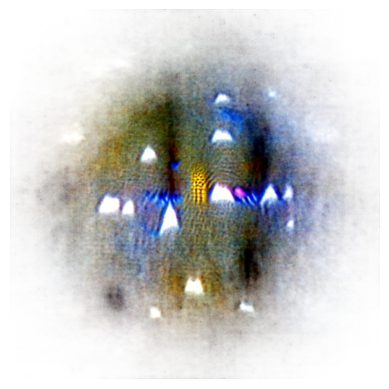

In [11]:
def objective(images):
    # Forward pass through the feature extractor
    images = normalizer(images)
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)[:, 44].mean()

maco_hyperparams = dict(total_steps=500, learning_rate=1.0, image_size=512,
        model_input_size=224, noise=0.50, values_range=(0, 1),
        crops_per_iteration=6, box_size=(0.20, 0.25),)
check_gradient(objective)
# Optimization part 1: MACO
image1, alpha1 = maco(objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)

torch.Size([])


100%|██████████| 500/500 [00:21<00:00, 23.15it/s]


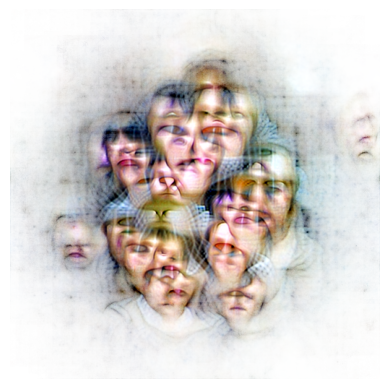

In [13]:
def objective(images):
    # Forward pass through the feature extractor
    # images = normalizer(images)
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)[:, 44].mean()

maco_hyperparams = dict(total_steps=500, learning_rate=1.0, image_size=512,
        model_input_size=224, noise=0.50, values_range=(-2.5, 2.5),
        crops_per_iteration=6, box_size=(0.20, 0.25),)
check_gradient(objective)
# Optimization part 1: MACO
image1, alpha1 = maco(objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)

torch.Size([])


100%|██████████| 500/500 [00:21<00:00, 23.12it/s]


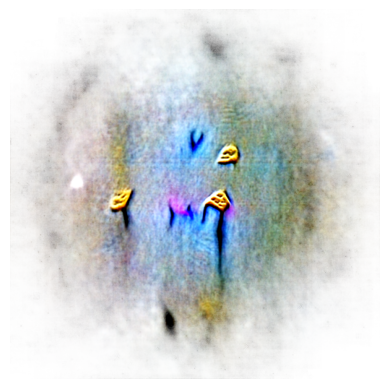

In [12]:
def objective(images):
    # Forward pass through the feature extractor
    images = normalizer(images)
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec).mean().mean()

maco_hyperparams = dict(total_steps=500, learning_rate=1.0, image_size=512,
        model_input_size=224, noise=1.0, values_range=(0, 1),
        crops_per_iteration=6, box_size=(0.20, 0.25),)
check_gradient(objective)
# Optimization part 1: MACO
image1, alpha1 = maco(objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)

torch.Size([])


100%|██████████| 500/500 [00:21<00:00, 23.13it/s]


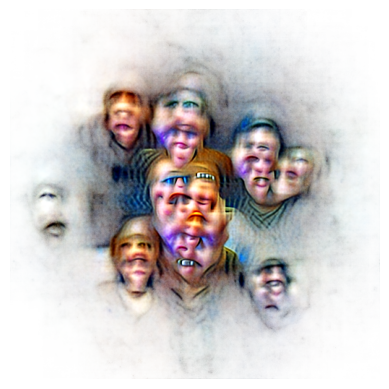

In [16]:
def objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec).mean().mean()

maco_hyperparams = dict(total_steps=500, learning_rate=1.0, image_size=512,
        model_input_size=224, noise=1.0, values_range=(-2.5, 2.5),
        crops_per_iteration=6, box_size=(0.20, 0.25),)
check_gradient(objective)
# Optimization part 1: MACO
image1, alpha1 = maco(objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)